## Introduction:  <a name="introduction"></a>

During this notebook, we will develop a deep learning model to use NLP to analyse and predict the score that a students essay will be graded at. The dataset was obtained from [kaggle](https://www.kaggle.com/c/asap-aes/overview) and contains a large number of short essays and the associated grade that they were given. 

## Contents:

1. [Introduction](#introduction)
2. [Preprocessing](#prepro)
    1. [Tokenising the text](#token)
    2. [Feature Engineering](#feat)
    3. [Padding the text](#pad)
    4. [Normalise essay score](#norm)
    5. [Train/Valid/Test split](#split)
3. [Building and training the model](#model)
4. [Evaluation and conclusion](#eval)

In [64]:
#setup libaries
#data manipulation
import numpy as np
import pandas as pd

#nlp
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import words #get english corpus of english words

#machine learning
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

#visuals
import matplotlib.pyplot as plt
import seaborn 

#misc
import chardet
from collections import Counter
from collections import defaultdict
import re

#check versions etc
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

[nltk_data] Error loading punkt: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


Version:  2.3.0
Eager mode:  True
Hub version:  0.8.0
GPU is NOT AVAILABLE


[nltk_data] Downloading package wordnet to /home/leon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /home/leon/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Loading dataset and preprocessing:  <a name="prepo"></a>

In [37]:
#find correct encoding 
with open('training_set.tsv','rb') as file:
    text = file.read(500)
    print(chardet.detect(text))

#load datasets
train_df = pd.read_csv('training_set.tsv',sep='\t',encoding=None,engine="python", quotechar='"', error_bad_lines=False)
valid_df = pd.read_csv('valid_set.tsv',sep='\t',encoding=None,engine="python", quotechar='"', error_bad_lines=False)
test_df = pd.read_csv('test_set.tsv',sep='\t',encoding=None,engine="python", quotechar='"', error_bad_lines=False)

Skipping line 9: '	' expected after '"'
Skipping line 139: '	' expected after '"'
Skipping line 225: '	' expected after '"'
Skipping line 379: '	' expected after '"'
Skipping line 542: '	' expected after '"'
Skipping line 603: '	' expected after '"'
Skipping line 650: '	' expected after '"'
Skipping line 668: '	' expected after '"'
Skipping line 841: '	' expected after '"'
Skipping line 846: '	' expected after '"'
Skipping line 850: '	' expected after '"'
Skipping line 867: '	' expected after '"'
Skipping line 909: '	' expected after '"'
Skipping line 911: '	' expected after '"'
Skipping line 940: '	' expected after '"'
Skipping line 988: '	' expected after '"'
Skipping line 1065: '	' expected after '"'
Skipping line 1068: '	' expected after '"'
Skipping line 1117: '	' expected after '"'
Skipping line 1169: '	' expected after '"'
Skipping line 1392: '	' expected after '"'


{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


Skipping line 1668: '	' expected after '"'
Skipping line 1724: '	' expected after '"'
Skipping line 6975: '	' expected after '"'
Skipping line 7479: '	' expected after '"'
Skipping line 7589: '	' expected after '"'
Skipping line 7670: '	' expected after '"'
Skipping line 7919: '	' expected after '"'
Skipping line 8184: '	' expected after '"'
Skipping line 8343: '	' expected after '"'
Skipping line 9541: '	' expected after '"'
Skipping line 9754: '	' expected after '"'
Skipping line 9873: '	' expected after '"'
Skipping line 10289: '	' expected after '"'
Skipping line 10775: '	' expected after '"'
Skipping line 11175: '	' expected after '"'
Skipping line 11178: '	' expected after '"'
Skipping line 11269: '	' expected after '"'
Skipping line 11341: '	' expected after '"'
Skipping line 11374: '	' expected after '"'
Skipping line 11637: '	' expected after '"'
Skipping line 11653: '	' expected after '"'
Skipping line 12023: '	' expected after '"'
Skipping line 12260: '	' expected after '"'


In [38]:
#subset datasets to columns of interest
train_df_select = train_df[['essay_id', 'essay_set', 'essay','domain1_score']]
valid_df_select = valid_df[['essay_id', 'essay_set', 'essay']]
test_df_select = test_df[['essay_id', 'essay_set', 'essay']]

In [39]:
#explore datasets
train_df_select.info()
train_df_select.describe()
train_df_select.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12921 entries, 0 to 12920
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   essay_id       12921 non-null  int64 
 1   essay_set      12921 non-null  int64 
 2   essay          12921 non-null  object
 3   domain1_score  12921 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 403.9+ KB


,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


In [40]:
#clean and preprocess text

#in this lemmatisation/stemming is not needed as 
#these contribute to the quality of the essay
#clean each review, remove punctuation and lower case text
def preprocess(text):
        #clean text
        clean_data = []
        new_text = re.sub(r'[^\w\s]', '', text) # remove punc.
        new_text = text.lower() # lower case     
        #if new_text != '':
        clean_data.append(new_text)
        #print('clean data: \n',clean_data)
        
        #remove stopwords
        stop_words = set(stopwords.words('english')) #define stopwords as set for faster processing.
        tk = WhitespaceTokenizer()
        word_tokens = tk.tokenize(clean_data[0]) 
        filtered_sentence = [] 
        for w in word_tokens: 
            if w not in stop_words: 
                filtered_sentence.append(w) 
        
        #print(filtered_sentence)        
        return(filtered_sentence)

#check to see function is performing correctly
preprocess(train_df_select.essay[10])

['dear',
 '@caps1',
 '@caps2',
 'feel',
 'computers',
 'take',
 'away',
 'peoples',
 'life',
 'aren�t',
 'important',
 'factors',
 'life.',
 'first',
 'know',
 'world',
 'becoming',
 'obease',
 'lack',
 'exercise.',
 'also',
 'people',
 'realize',
 '@caps3',
 'warming',
 'becomeing',
 'big',
 'problum.',
 'finally',
 'familys',
 "arn't",
 'close',
 'used',
 'be.',
 'reasons',
 'computers',
 "arn't",
 'important',
 'human',
 'socioty.',
 'first',
 'world',
 'becomeing',
 'obease',
 'cumputers',
 'play',
 'huge',
 'part',
 'this.',
 'computers',
 'make',
 'people',
 'exercise',
 'basicly',
 'sit',
 'couch',
 'use',
 'computer',
 'help',
 'amarica',
 'get',
 'back',
 'shape.',
 'also',
 'computers',
 'become',
 'habbit',
 'person',
 'uses',
 'computer',
 'everyday',
 'life',
 'become',
 'addiction',
 'able',
 'stop.',
 'finally',
 'people',
 'use',
 'computer',
 'realize',
 'lack',
 'exersise',
 'getting.',
 'first',
 'reason',
 'computeres',
 'bad',
 'thing.',
 'next',
 '@caps3',
 'warmi

In [41]:
#apply text preprocessing to all reviews in dataset
train_df_select['essay_pre'] = train_df_select['essay'].apply(preprocess) #create new column with preprocessed essay
#check a preprocessed review
train_df_select['essay_pre'][10]

<ipython-input-41-a6899f19d695>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_select['essay_pre'] = train_df_select['essay'].apply(preprocess) #create new column with preprocessed essay


['dear',
 '@caps1',
 '@caps2',
 'feel',
 'computers',
 'take',
 'away',
 'peoples',
 'life',
 'aren�t',
 'important',
 'factors',
 'life.',
 'first',
 'know',
 'world',
 'becoming',
 'obease',
 'lack',
 'exercise.',
 'also',
 'people',
 'realize',
 '@caps3',
 'warming',
 'becomeing',
 'big',
 'problum.',
 'finally',
 'familys',
 "arn't",
 'close',
 'used',
 'be.',
 'reasons',
 'computers',
 "arn't",
 'important',
 'human',
 'socioty.',
 'first',
 'world',
 'becomeing',
 'obease',
 'cumputers',
 'play',
 'huge',
 'part',
 'this.',
 'computers',
 'make',
 'people',
 'exercise',
 'basicly',
 'sit',
 'couch',
 'use',
 'computer',
 'help',
 'amarica',
 'get',
 'back',
 'shape.',
 'also',
 'computers',
 'become',
 'habbit',
 'person',
 'uses',
 'computer',
 'everyday',
 'life',
 'become',
 'addiction',
 'able',
 'stop.',
 'finally',
 'people',
 'use',
 'computer',
 'realize',
 'lack',
 'exersise',
 'getting.',
 'first',
 'reason',
 'computeres',
 'bad',
 'thing.',
 'next',
 '@caps3',
 'warmi

### Tokenise essays  <a name="token"></a>

In [42]:
#tokenise essays
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=2000,
    filters='"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token='<OOV>')

tokenizer.fit_on_texts(train_df_select.essay_pre.values) #fit tokeniser on all essays 
word_index = tokenizer.word_index #check to see that a word index has been made 
word_index

{'<OOV>': 1,
 'people': 2,
 'would': 3,
 'like': 4,
 'one': 5,
 'computers': 6,
 'get': 7,
 '@caps1': 8,
 'could': 9,
 'think': 10,
 'time': 11,
 'many': 12,
 'also': 13,
 'computer': 14,
 'go': 15,
 'things': 16,
 'books': 17,
 'even': 18,
 'author': 19,
 'building': 20,
 'make': 21,
 'know': 22,
 '@caps2': 23,
 'way': 24,
 'going': 25,
 'parents': 26,
 'take': 27,
 'good': 28,
 'book': 29,
 'want': 30,
 'family': 31,
 'new': 32,
 'see': 33,
 'got': 34,
 'story': 35,
 'something': 36,
 'state': 37,
 'much': 38,
 'us': 39,
 'mood': 40,
 'use': 41,
 'read': 42,
 'it.': 43,
 'find': 44,
 'empire': 45,
 'dirigibles': 46,
 'always': 47,
 'help': 48,
 'offensive': 49,
 'really': 50,
 'another': 51,
 'said': 52,
 '@caps3': 53,
 'back': 54,
 'need': 55,
 'friends': 56,
 'children': 57,
 'cyclist': 58,
 'life': 59,
 'around': 60,
 'day': 61,
 'kids': 62,
 'made': 63,
 'say': 64,
 '@month1': 65,
 'never': 66,
 'thing': 67,
 'library': 68,
 'reason': 69,
 'first': 70,
 'right': 71,
 'someone': 7

In [43]:
#create array of tokenised reviews
tokenized = tokenizer.texts_to_sequences(train_df_select.essay_pre.values)

In [44]:
#add tokenised review to df
train_df_select['tokenised_reviews'] = tokenized
train_df_select.head()

<ipython-input-44-b03238ba88aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_select['tokenised_reviews'] = tokenized


,essay_id,essay_set,essay,domain1_score,essay_pre,tokenised_reviews
0,1,1,"Dear local newspaper, I think effects computer...",8,"[dear, local, newspaper,, think, effects, comp...","[198, 379, 529, 10, 449, 6, 2, 87, 393, 1, 124..."
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,"[dear, @caps1, @caps2,, believe, using, comput...","[198, 8, 488, 82, 195, 6, 536, 39, 12, 352, 4,..."
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,"[dear,, @caps1, @caps2, @caps3, people, use, c...","[1, 8, 23, 53, 2, 41, 552, 78, 1, 986, 396, 79..."
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,"[dear, local, newspaper,, @caps1, found, many,...","[198, 379, 529, 8, 138, 12, 1458, 64, 6, 1606,..."
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,"[dear, @location1,, know, computers, positive,...","[198, 594, 22, 6, 234, 185, 128, 6, 1250, 1681..."


### Feature Engineering  <a name="feat"></a>

Next we will perform some feature engineering to see if we can add some useful features to be fed into the machine learning model. First we will try and identify the proportion of words in an essay that have been spelt correctly vs spelt incorrectly.

In [45]:
wordset = set(words.words()) #save english words as a set for faster processing

#count words in essay
def count_words(text):
    word_count = Counter(text) #count words
    new_count = {k: v for k, v in sorted(word_count.items(),reverse=True, key=lambda item: item[1])} #order from highest words to lowest
    new_count2 = {}
    for keys in new_count.keys(): #remove any counts starting with @ and return new dict with words in order of highest frequency to lowest
        if keys[0] !='@':
            new_count2.update({keys:new_count[keys]})
        else:
            pass
    return(new_count2)
     
    
#count actual words vs misspelt words
def prop_good_words(input_dict):
    actual_words = 0
    wrong_words = 0
    
    #loop through counter keys
    for key in input_dict.keys():
        if key[-1] == '.' or key[-1] == 's' or key[-1] == ',' : #remove punctuation and plurals
            new_key = key[:-1]
        else:
            new_key = key
        #print(new_key)

        if (str(new_key) in wordset) == True: #check if word is in set of all english words
            #print('yes')
            actual_words = actual_words + int(input_dict[key]) #add number of correct words to total
        elif (str(new_key) in wordset) == False: #check if word if incorrectly spelled
            #print('no')
            wrong_words = wrong_words + int(input_dict[key]) #add number of incorrect words to total
        else: #should never be called
            print('error')
            pass

    return(actual_words,wrong_words) #return counts

#calculates proportions of correctly spelt words to total
def get_prop(text):
    temp_count = prop_good_words(count_words(text)) #returns count of actual words vs misspelt words
    prop_good = round(temp_count[0]/len(text),3) #divides count of correctly spelt words by total words in essay
    prop_bad = round(temp_count[1]/len(text),3) #divides count of incorrectly spelt words by total words
    return (prop_good,prop_bad)

#check
get_prop(train_df_select['essay_pre'][10])
    

(0.776, 0.184)

In [46]:
#find proportions of good/bad words and length of essay for all essays
train_df_select['prop_good'] = train_df_select['essay_pre'].map(lambda x:get_prop(x)[0])
train_df_select['prop_bad'] = train_df_select['essay_pre'].map(lambda x:get_prop(x)[1])
train_df_select['length'] = train_df_select['essay_pre'].map(lambda x: len(x))

<ipython-input-46-d05f14e90ea6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_select['prop_good'] = train_df_select['essay_pre'].map(lambda x:get_prop(x)[0])
<ipython-input-46-d05f14e90ea6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_select['prop_bad'] = train_df_select['essay_pre'].map(lambda x:get_prop(x)[1])
<ipython-input-46-d05f14e90ea6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [47]:
#check
train_df_select.head()

,essay_id,essay_set,essay,domain1_score,essay_pre,tokenised_reviews,prop_good,prop_bad,length
0,1,1,"Dear local newspaper, I think effects computer...",8,"[dear, local, newspaper,, think, effects, comp...","[198, 379, 529, 10, 449, 6, 2, 87, 393, 1, 124...",0.759,0.212,170
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,"[dear, @caps1, @caps2,, believe, using, comput...","[198, 8, 488, 82, 195, 6, 536, 39, 12, 352, 4,...",0.796,0.161,230
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,"[dear,, @caps1, @caps2, @caps3, people, use, c...","[1, 8, 23, 53, 2, 41, 552, 78, 1, 986, 396, 79...",0.827,0.122,139
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,"[dear, local, newspaper,, @caps1, found, many,...","[198, 379, 529, 8, 138, 12, 1458, 64, 6, 1606,...",0.675,0.195,302
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,"[dear, @location1,, know, computers, positive,...","[198, 594, 22, 6, 234, 185, 128, 6, 1250, 1681...",0.821,0.162,229


In [48]:
#check correlations
print(train_df_select.prop_good.corr(train_df_select.domain1_score))
print(train_df_select.prop_bad.corr(train_df_select.domain1_score))
print(train_df_select.length.corr(train_df_select.domain1_score))

-0.1429456916093645
-0.08200486851687126
0.5778836860548487


We see that the proportion of correctly spelt words and incorrectly spelt words does not have a large correlation with the score an essay receives. We do however see that the length of an essay has a relatively strong positive association with the grade an essay receives. 

However the added complexity of developing a model with numerical inputs as well as textual inputs should be weighed against the expected benefit of adding textual data to the input pipeline. We will develop a ML model without the textual data as input and see how the model performs and then decide whether to change the pipeline later.

### Padding the essay texts  <a name="pad"></a>

We want all of the essays to be padded to a uniform length so that the ML model can process them correctly. We will look at the distributions of essay length and decide what is an appropiate length to set the essays to.

count    12921.000000
mean       111.393236
std         87.659305
min          1.000000
25%         48.000000
50%         84.000000
75%        152.000000
max        539.000000
Name: length, dtype: float64


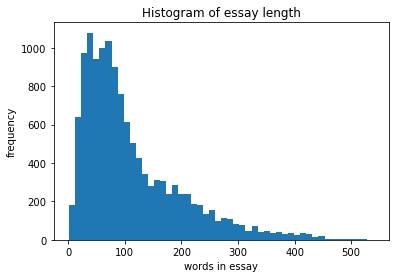

In [49]:
#check stats for review length
print(train_df_select.length.describe())

#check histrogram of review length
plt.hist(train_df_select.length.values,bins=50)
plt.xlabel('words in essay')
plt.ylabel('frequency')
plt.title('Histogram of essay length')
plt.show()

We see that the essay length is biased towards lengths of around 100. It seems like 300 words could achieve a good balance between processing time and capturing most of the information within the essay

In [50]:
#pad the tokenised reviews to give uniform length
padded=pad_sequences(tokenized,padding='post',truncating='post',maxlen=300)

### Normalise essay scores  <a name="norm"></a>

Now we normalise the scores that each essay received to make it easier for the neural network to make inferences about the score each essay should be given.

count    12921.000000
mean         6.760777
std          8.931878
min          0.000000
25%          2.000000
50%          3.000000
75%          8.000000
max         60.000000
Name: domain1_score, dtype: float64


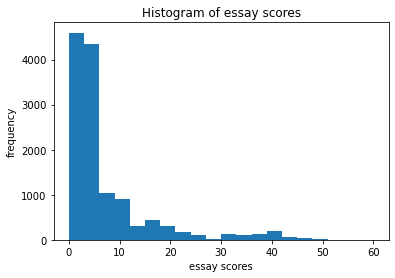

In [51]:
#check score distributions
print(train_df_select.domain1_score.describe())

#check histrogram of review length
plt.hist(train_df_select.domain1_score.values,bins=20)
plt.xlabel('essay scores')
plt.ylabel('frequency')
plt.title('Histogram of essay scores')
plt.show()

We see that most essays have been graded in the 0-20 range with only a relatively small number of essays being given higher scores.

In [52]:
#normalise the essay scores
scaler = MinMaxScaler()
scaler.fit(train_df_select[['domain1_score']])
train_df_select['score_norm'] = scaler.transform(train_df_select[['domain1_score']])

#check
train_df_select.head()
#train_df_select.score_norm.value_counts(ascending=False)

<ipython-input-52-4b3c57f8c51e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_select['score_norm'] = scaler.transform(train_df_select[['domain1_score']])


,essay_id,essay_set,essay,domain1_score,essay_pre,tokenised_reviews,prop_good,prop_bad,length,score_norm
0,1,1,"Dear local newspaper, I think effects computer...",8,"[dear, local, newspaper,, think, effects, comp...","[198, 379, 529, 10, 449, 6, 2, 87, 393, 1, 124...",0.759,0.212,170,0.133333
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,"[dear, @caps1, @caps2,, believe, using, comput...","[198, 8, 488, 82, 195, 6, 536, 39, 12, 352, 4,...",0.796,0.161,230,0.150000
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,"[dear,, @caps1, @caps2, @caps3, people, use, c...","[1, 8, 23, 53, 2, 41, 552, 78, 1, 986, 396, 79...",0.827,0.122,139,0.116667
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,"[dear, local, newspaper,, @caps1, found, many,...","[198, 379, 529, 8, 138, 12, 1458, 64, 6, 1606,...",0.675,0.195,302,0.166667
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,"[dear, @location1,, know, computers, positive,...","[198, 594, 22, 6, 234, 185, 128, 6, 1250, 1681...",0.821,0.162,229,0.133333


### Splitting the data into training/validation/test splits  <a name="split"></a>

In [53]:
#split into train,valid,test split
x_train, x_val_test, y_train, y_val_test = train_test_split(padded,train_df_select.score_norm,
                                                            train_size=0.8, shuffle=True) #split into train and validation/test sets

x_val,x_test, y_val,y_test = train_test_split(x_val_test, y_val_test,
                                                            train_size=0.5, shuffle=True) #split val/test into valid and test sets

In [54]:
#check the numbers in each set
print('xtrain: ',len(x_train))
print('ytrain: ',len(y_train))
print('xval: ',len(x_val))
print('yval: ',len(y_val))
print('xtest: ',len(x_test))
print('ytest: ',len(y_test))

xtrain:  10336
ytrain:  10336
xval:  1292
yval:  1292
xtest:  1293
ytest:  1293


## Develop the model:  <a name="model"></a>

### Define the model:

In [55]:
#define hyperparameters
vocab_size = 2000 
embedding_dim = 64
rnn_units = 256
batch_size = 64

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size + 1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
    tf.keras.layers.Lambda(lambda x:20*x)]) #speeds up training by amplifyng differences

#other models tried
#basic pooling model
# model = tf.keras.Sequential([
#   tf.keras.layers.Embedding(max_features + 1, embedding_dim),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.GlobalAveragePooling1D(),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(1)])

#model with GRU
# model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(max_features + 1, embedding_dim, batch_input_shape),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.GRU(rnn_units,
#                             return_sequences=True,
#                             stateful=True,
#                             recurrent_initializer='glorot_uniform'),
#         tf.keras.layers.Dense(vocab_size),
#         tf.keras.layers.Dense(1),
#     ])




In [56]:
#set callbacks
callback1 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10,restore_best_weights = True)

callback2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse', patience=4, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

callbacks = [callback1,callback2]

In [57]:
#compile model
model.compile(loss='mse',
              optimizer='rmsprop',metrics=['mse'])

### Train the model:

In [58]:
#tf.keras.backend.clear_session()
x_val

array([[ 340,   41,  729, ...,    0,    0,    0],
       [  19,  237,   35, ...,    0,    0,    0],
       [  49,    8,   23, ...,    0,    0,    0],
       ...,
       [  69,   10,   19, ...,    0,    0,    0],
       [   1,  125,   19, ...,    0,    0,    0],
       [ 705, 1044,  269, ...,    0,    0,    0]], dtype=int32)

In [59]:
history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, verbose=2, callbacks=callbacks,
    steps_per_epoch=10,validation_data = (np.asarray(x_val),np.asarray(y_val)),
    validation_steps=5,validation_freq=5,validation_batch_size=32,
    max_queue_size=10, workers=1, use_multiprocessing=False)


Epoch 1/50
10/10 - 12s - loss: 0.1083 - mse: 0.1083
Epoch 2/50
10/10 - 12s - loss: 0.0315 - mse: 0.0315
Epoch 3/50
10/10 - 11s - loss: 0.0240 - mse: 0.0240
Epoch 4/50
10/10 - 10s - loss: 0.0319 - mse: 0.0319
Epoch 5/50
10/10 - 14s - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 6/50
10/10 - 11s - loss: 0.0240 - mse: 0.0240
Epoch 7/50
10/10 - 10s - loss: 0.0270 - mse: 0.0270
Epoch 8/50
10/10 - 11s - loss: 0.0503 - mse: 0.0503
Epoch 9/50
10/10 - 10s - loss: 0.0208 - mse: 0.0208
Epoch 10/50
10/10 - 13s - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0343 - val_mse: 0.0343
Epoch 11/50
10/10 - 14s - loss: 0.0168 - mse: 0.0168
Epoch 12/50
10/10 - 16s - loss: 0.0127 - mse: 0.0127
Epoch 13/50
10/10 - 14s - loss: 0.0109 - mse: 0.0109
Epoch 14/50
10/10 - 12s - loss: 0.0126 - mse: 0.0126
Epoch 15/50
10/10 - 14s - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 16/50
10/10 - 12s - loss: 0.0144 - mse: 0.0144
Epoch 17/50
10/10 - 18s - loss: 0.0118 - mse: 0.01

## Evaluate the model:  <a name="eval"></a>

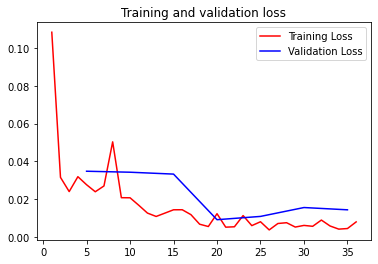

<Figure size 432x288 with 0 Axes>

In [60]:
#define variables of interest from history variable
# mse = history.history['sparse_categorical_accuracy']
# val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1,1)
epochs2 = range(5,len(val_loss)*5+1,5)

# #create graphs
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs2, val_loss, 'b', label='Validation Loss')

plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.show()

In [61]:
#make predictions on validation date
y_preds = model.predict(x_val)

#apply inverse transform so predictions match actual scores
y_preds_denorm = scaler.inverse_transform(y_preds) #inverse transform predictions
df_y_val = pd.DataFrame(y_val) 
y_val_denorm = scaler.inverse_transform(df_y_val[['score_norm']]) #inverse transform validation y values

#create a new dataframe with the predictions
df_y_preds = pd.DataFrame(y_preds_denorm)

#create a new dataframe with integers by rounding the previous values to 0 decimal places and converting to int type
df_y_preds_int = df_y_preds.round(0).astype(int)

#can't have values of 0
df_y_preds_int = df_y_preds_int.replace(to_replace=0,value=1)

#check to see the above steps have been applied correctly
df_y_preds_int.head()



,0
0,24
1,1
2,10
3,16
4,1


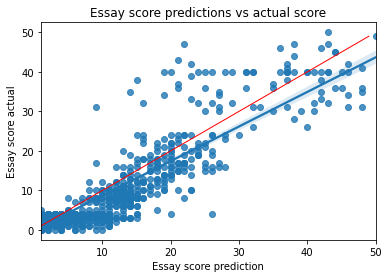

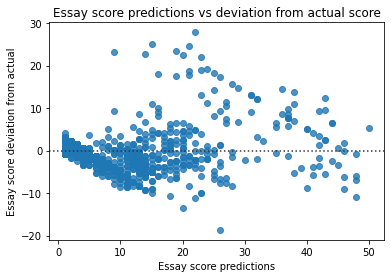

In [62]:
#check residual plots
seaborn.regplot(x=df_y_preds_int,y=y_val_denorm,scatter_kws={'alpha':0.8})
plt.plot(range(1,50),range(1,50), color = 'red', linewidth = 1)
plt.xlabel('Essay score prediction')
plt.ylabel('Essay score actual')
plt.title('Essay score predictions vs actual score')
plt.show()

seaborn.residplot(x=df_y_preds_int,y=y_val_denorm,scatter_kws={'alpha':0.8})
plt.xlabel('Essay score predictions')
plt.ylabel('Essay score deviation from actual')
plt.title('Essay score predictions vs deviation from actual score')
plt.show()

In [63]:
print('mae: ',mae(df_y_preds_int,y_val_denorm))
print('r2: ',r2(df_y_preds_int,y_val_denorm))

mae:  3.0874613003095974
r2:  0.7819656397023771


We can see that in general the machine learning model is getting close to the correct essay scores for actual essay scores between 0 and 10 and the model is able to make predicitons that are within +5 or -5 from the actual scores. We do see that as the essay scores increase, the model is not able to make as accurate predictions about the essay scores as the predicted scores are a lot lower than the actual scores.

This suggests that the model is able to handle lower scores a lot better than higher scores and perhaps if a prediction of a high score is made, a student essay could be flagged for maual review by a teacher.